# 电化学部分的建模使用拟合经验模型的方法

## import需要的库

In [1]:
import os,gzip,pickle
from keys import DataDir,Cols
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split
import math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 替换为你系统中支持中文的字体路径，这里以黑体为例
prop = fm.FontProperties(fname=font_path)

## 导入数据与数据预处理

In [2]:
with gzip.open(
    r'D:\Devs\Simulation-Platform\data\processed\Test data Hyzenis\2025.04.08-8.30-2025.04.11-17.30-10s-1# gzip',
    'rb'
) as f:
    df_Hyzenis = pickle.load(f)

In [3]:
df_date_Hyzenis = df_Hyzenis.query(
    f"'2025-04-08 00:00:00'<{Cols.date_time}<'2025-04-10 12:00:00'"
)

In [4]:
print(df_date_Hyzenis[Cols.voltage].max())

63.3897590637207


### 筛选数据点

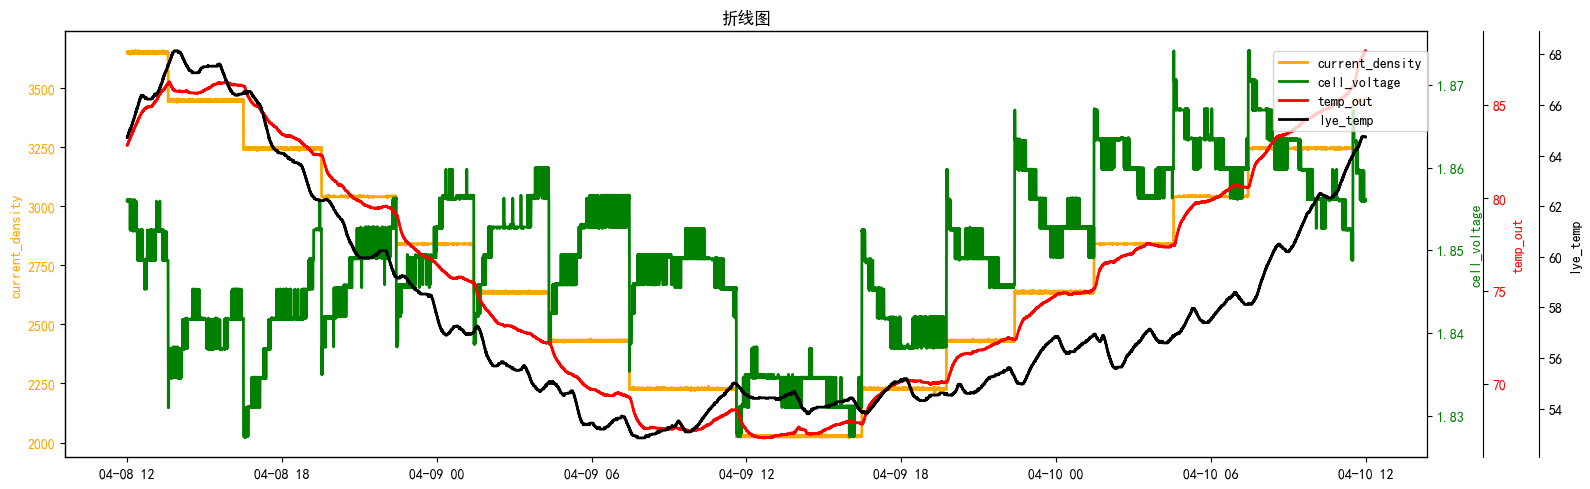

In [7]:
from utils.drawing_methods import LinePlotter

lineplotter = LinePlotter()

Y = df_date_Hyzenis[[Cols.current_density, Cols.cell_voltage, Cols.temp_out, Cols.lye_temp]]
colors = {Cols.current_density: 'orange',
          Cols.cell_voltage: 'green',
          Cols.temp_out : 'red',
          Cols.lye_temp : 'black'}
plot, ax = lineplotter.multiple_variable_plot(x_data=df_date_Hyzenis[Cols.date_time], Y_data=Y, color = colors)

In [8]:
# 计算简单移动平均（窗口大小=10）
df_voltage_Hyzenis = df_date_Hyzenis
df_voltage_Hyzenis[Cols.cell_voltage] = df_voltage_Hyzenis[Cols.cell_voltage].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留

C:\Users\Orz\AppData\Local\Temp\ipykernel_79752\1771773567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voltage_Hyzenis[Cols.cell_voltage] = df_voltage_Hyzenis[Cols.cell_voltage].rolling(window=10, min_periods=1, center=True).mean()  # min_periods=1 确保首个数据直接保留


In [9]:
# 计算当前行温度与后一行温度的变化率
df_static_Hyzenis = df_voltage_Hyzenis

# 计算前后 100 个点（窗口大小为 201）的极差
window_size = 201
df_static_Hyzenis['temp_diff'] = df_static_Hyzenis[Cols.temp_out].rolling(window=window_size, center=True, min_periods=1).apply(lambda x: x.max() - x.min())

# 筛选出温度变化值小于 0.3 的行
df_static_Hyzenis = df_static_Hyzenis[df_static_Hyzenis['temp_diff'] < 0.3]

C:\Users\Orz\AppData\Local\Temp\ipykernel_79752\2643116675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_static_Hyzenis['temp_diff'] = df_static_Hyzenis[Cols.temp_out].rolling(window=window_size, center=True, min_periods=1).apply(lambda x: x.max() - x.min())


#### 冷却流量比

In [17]:
Num_Cells = 31
Diameter_Electrode = 560 * 1E-3
Width_Cell = 5 * 1E-3

Volume_active = math.pi * (Diameter_Electrode / 2) ** 2 * Width_Cell * Num_Cells
lambda_flow_range = df_static_Hyzenis[Cols.lye_flow] / Volume_active / 13 - 0.25

print(lambda_flow_range.min(), lambda_flow_range.max())

0.40622820971850426 0.6050752783951647


## 在基础公式的基础上拟合经验参数(部分拟合)

### 定义经验公式

In [18]:
Faraday = 96485
R = 8.314

# 定义经验公式
def Vrev_cal(lye_temp, temp_out, pressure):
    temp_work = (lye_temp + temp_out) / 2 + 273

    temp_ref = 298  # 参考点温度: K
    pressure_ref = 1  # 参考点压力: bar
    pressure = pressure * 10  # 公式中压力单位bar，单位转换
    z = 2  # 单位摩尔反应转移的电子数: mol

    delta_H0_H2O = -2.86E5  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_H2 = 0  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_O2 = 0  # 参考点状态下的焓变(单位：J / mol)

    s0_H2O = 70  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_H2 = 131  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_O2 = 205  # 参考点状态下的熵值(单位：J / (K * mol))

    Cp0_H2O = 75  # 参考点状态下的水热容(单位：J / (K * mol))
    Cp0_H2 = 29  # 参考点状态下的氢气热容(单位：J / (K * mol))
    Cp0_O2 = 29  # 参考点状态下的氧气热容(单位：J / (K * mol))

    delta_H_H2 = Cp0_H2 * (temp_work - temp_ref) + delta_H0_H2
    delta_H_O2 = Cp0_O2 * (temp_work - temp_ref) + delta_H0_O2
    delta_H_H2O = Cp0_H2O * (temp_work - temp_ref) + delta_H0_H2O
    delta_H = delta_H_H2 + 0.5 * delta_H_O2 - delta_H_H2O

    S_H2 = Cp0_H2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_H2
    S_O2 = Cp0_O2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_O2
    S_H2O = Cp0_H2O * torch.log(temp_work / temp_ref) + s0_H2O

    Delta_S = S_H2 + 0.5 * S_O2 - S_H2O

    delta_G = delta_H - temp_work * Delta_S
    
    Vrev = delta_G / (z * Faraday)  # 可逆电压

    return Vrev


def cell_voltage_cal_empirical_formula(statistics, r1, r2, s1, t1, t2, t3, c1, c2):
    lye_temp = statistics[0]
    temp_out = statistics[1]
    current_density = statistics[2]
    lye_flow = statistics[3]
    pressure = statistics[4]

    Vrev = Vrev_cal(lye_temp = lye_temp,
                    temp_out = temp_out,
                    pressure = pressure)
    
    # 避免 lye_temp 或 temp_out 为零
    lye_temp = torch.clamp(lye_temp, min=1e-10)
    temp_out = torch.clamp(temp_out, min=1e-10)

    lambda_flow = lye_flow / Volume_active / 25 + 0.1

    temp_work = torch.sqrt(torch.clamp((1 - lambda_flow) * lye_temp ** 2 * c1 + lambda_flow * temp_out ** 2 * c2, min = 1E-10))
    
    # 避免 log 函数的负数输入
    log_input = torch.clamp((t1 + t2 / temp_work + t3 / temp_work ** 2) * current_density + 1, min=1e-10)

    Vcell = (r1 + r2 * temp_work) * current_density + s1 * torch.log(log_input) + Vrev
    
    return Vcell

In [ ]:
Faraday = 96485
R = 8.314

# 定义经验公式
def Vrev_cal(lye_temp, temp_out, pressure):
    temp_work = (lye_temp + temp_out) / 2 + 273

    temp_ref = 298  # 参考点温度: K
    pressure_ref = 1  # 参考点压力: bar
    pressure = pressure * 10  # 公式中压力单位bar，单位转换
    z = 2  # 单位摩尔反应转移的电子数: mol

    delta_H0_H2O = -2.86E5  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_H2 = 0  # 参考点状态下的焓变(单位：J / mol)
    delta_H0_O2 = 0  # 参考点状态下的焓变(单位：J / mol)

    s0_H2O = 70  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_H2 = 131  # 参考点状态下的熵值(单位：J / (K * mol))
    s0_O2 = 205  # 参考点状态下的熵值(单位：J / (K * mol))

    Cp0_H2O = 75  # 参考点状态下的水热容(单位：J / (K * mol))
    Cp0_H2 = 29  # 参考点状态下的氢气热容(单位：J / (K * mol))
    Cp0_O2 = 29  # 参考点状态下的氧气热容(单位：J / (K * mol))

    delta_H_H2 = Cp0_H2 * (temp_work - temp_ref) + delta_H0_H2
    delta_H_O2 = Cp0_O2 * (temp_work - temp_ref) + delta_H0_O2
    delta_H_H2O = Cp0_H2O * (temp_work - temp_ref) + delta_H0_H2O
    delta_H = delta_H_H2 + 0.5 * delta_H_O2 - delta_H_H2O

    S_H2 = Cp0_H2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_H2
    S_O2 = Cp0_O2 * torch.log(temp_work / temp_ref) - R * torch.log(pressure / pressure_ref) + s0_O2
    S_H2O = Cp0_H2O * torch.log(temp_work / temp_ref) + s0_H2O

    Delta_S = S_H2 + 0.5 * S_O2 - S_H2O

    delta_G = delta_H - temp_work * Delta_S
    
    Vrev = delta_G / (z * Faraday)  # 可逆电压

    return Vrev


def cell_voltage_cal_empirical_formula(statistics, r1, r2, s1, t1, t2, t3, c1, c2):
    lye_temp = statistics[0]
    temp_out = statistics[1]
    current_density = statistics[2]
    lye_flow = statistics[3]
    pressure = statistics[4]

    Vrev = Vrev_cal(lye_temp = lye_temp,
                    temp_out = temp_out,
                    pressure = pressure)
    
    # 避免 lye_temp 或 temp_out 为零
    lye_temp = torch.clamp(lye_temp, min=1e-10)
    temp_out = torch.clamp(temp_out, min=1e-10)

    lambda_flow = lye_flow / Volume_active / 13 - 0.25

    temp_work = (1 - lambda_flow) * lye_temp * c1 + lambda_flow * temp_out * c2
    
    # 避免 log 函数的负数输入
    log_input = torch.clamp((t1 + t2 / temp_work + t3 / temp_work ** 2) * current_density + 1, min=1e-10)

    Vcell = (r1 + r2 * temp_work) * current_density + s1 * torch.log(log_input) + Vrev
    
    return Vcell

### 使用pytorch实现梯度下降优化

In [21]:
# 检查是否有 GPU 可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


#### 提取观测数据列

In [22]:
feature_cols = [Cols.lye_temp, Cols.temp_out, Cols.current_density, Cols.lye_flow, '氢分离器压力']
target_cols = [Cols.cell_voltage]

statistics = df_static_Hyzenis[feature_cols]
cell_voltage_observed = df_static_Hyzenis[target_cols]

statistics_torch = torch.tensor(statistics.values.T, dtype=torch.float32)
cell_voltage_observed_torch = torch.tensor(cell_voltage_observed.values.T, dtype=torch.float32)

statistics_torch = statistics_torch.to(device)
cell_voltage_observed_torch = cell_voltage_observed_torch[0].to(device)

# 计算训练集和测试集的大小
total_size = statistics_torch.shape[1]
train_size = int(0.8 * total_size)
test_size = total_size - train_size


# 随机划分数据
train_indices, test_indices = random_split(range(total_size), [train_size, test_size])

# 根据划分的索引获取训练集和测试集
statistics_torch_train = statistics_torch[:, train_indices.indices]
cell_voltage_observed_torch_train = cell_voltage_observed_torch[train_indices.indices]

statistics_torch_test = statistics_torch[:, test_indices.indices]
cell_voltage_observed_torch_test = cell_voltage_observed_torch[test_indices.indices]

print(f"训练集大小: {statistics_torch_train.shape[1]}")
print(f"测试集大小: {statistics_torch_test.shape[1]}")

训练集大小: 4348
测试集大小: 1087


#### 初始化需要拟合的参数（减小初始值范围）

In [23]:
# 直接赋值初始化
init_values = [8e-5, -2e-7, 2e-1, 1, 1e1, 2e2,
               1, 1
]
param_names = [
     'r1', 'r2', 's1', 't1', 't2', 't3',
     'c1', 'c2'
]

params = {name: torch.tensor([value], dtype=torch.float32, requires_grad = True) for name, value in zip(param_names, init_values)}
params = {k: torch.nn.Parameter(v.to(device)) for k, v in params.items()}

#### 训练

##### 分学习率训练

In [24]:
# 定义损失函数
criterion = torch.nn.MSELoss()

# 分四类设置学习率
lr1 = 1e-9
lr2 = 1e-3
lr3 = 1
lr4 = 1e-3

# 设置训练边界
tolerance = 1e-6

# 分离参数，按照不同学习率分类
paramsr_list = [params['r1'], params['r2']]
paramss_list = [params['s1'], params['t1'], params['t2']]
paramst_list = [params['t3']]
paramsc_list = [params['c1'], params['c2']]

# 使用单个优化器管理多参数组
optimizer = torch.optim.AdamW([
    {'params': paramsr_list, 'lr': lr1},
    {'params': paramss_list, 'lr': lr2},
    {'params': paramst_list, 'lr': lr3},
    {'params': paramsc_list, 'lr': lr4}
], weight_decay=1e-4)

# 早停策略参数
patience = 1000
best_test_loss = float('inf')
counter = 0

# 训练循环
num_epochs = 900000

for epoch in range(num_epochs):
    # 训练步骤
    optimizer.zero_grad()
    
    # 训练数据前向传播
    cell_voltage_pred_train = cell_voltage_cal_empirical_formula(statistics_torch_train, **params)
    train_loss = criterion(cell_voltage_pred_train, cell_voltage_observed_torch_train)
    
    # 反向传播与优化
    train_loss.backward()
    optimizer.step()

    # # 参数约束：确保c1和c2在[0.9, 1.1]范围内
    # with torch.no_grad():
    #     params['c1'].clamp_(min=0.9, max=1)
    #     params['c2'].clamp_(min=0.9, max=1)
    
    # 验证步骤
    with torch.no_grad():
        cell_voltage_pred_test = cell_voltage_cal_empirical_formula(statistics_torch_test, **params)
        test_loss = criterion(cell_voltage_pred_test, cell_voltage_observed_torch_test)
    
    # 每50个epoch打印信息
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss.item():.4e}, test Loss: {test_loss.item():.4e}')
    
    # 早停策略
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}, best test loss: {best_test_loss:.4e}")
            break
    
    # 收敛条件检查
    if train_loss.item() < tolerance:
        print(f"训练损失达到收敛条件 (<{tolerance})")
        break

# 最终结果输出
print("训练完成，最终验证损失：", best_test_loss.item())


Epoch 0, Train Loss: 1.4055e+00, test Loss: 1.3897e+00
Epoch 50, Train Loss: 6.1747e-01, test Loss: 6.0847e-01
Epoch 100, Train Loss: 2.2436e-01, test Loss: 2.2054e-01
Epoch 150, Train Loss: 6.6657e-02, test Loss: 6.5429e-02
Epoch 200, Train Loss: 1.6062e-02, test Loss: 1.5806e-02
Epoch 250, Train Loss: 3.3688e-03, test Loss: 3.3643e-03
Epoch 300, Train Loss: 9.0604e-04, test Loss: 9.3434e-04
Epoch 350, Train Loss: 5.3741e-04, test Loss: 5.6005e-04
Epoch 400, Train Loss: 4.9388e-04, test Loss: 5.1137e-04
Epoch 450, Train Loss: 4.8844e-04, test Loss: 5.0393e-04
Epoch 500, Train Loss: 4.8623e-04, test Loss: 5.0112e-04
Epoch 550, Train Loss: 4.8412e-04, test Loss: 4.9881e-04
Epoch 600, Train Loss: 4.8189e-04, test Loss: 4.9648e-04
Epoch 650, Train Loss: 4.7953e-04, test Loss: 4.9404e-04
Epoch 700, Train Loss: 4.7706e-04, test Loss: 4.9148e-04
Epoch 750, Train Loss: 4.7446e-04, test Loss: 4.8880e-04
Epoch 800, Train Loss: 4.7175e-04, test Loss: 4.8599e-04
Epoch 850, Train Loss: 4.6892e-04,

## 训练结果

### 打印参数结果

In [25]:
print(params)

{'r1': Parameter containing:
tensor([8.1262e-05], device='cuda:0', requires_grad=True), 'r2': Parameter containing:
tensor([-6.9851e-07], device='cuda:0', requires_grad=True), 's1': Parameter containing:
tensor([0.0835], device='cuda:0', requires_grad=True), 't1': Parameter containing:
tensor([0.0776], device='cuda:0', requires_grad=True), 't2': Parameter containing:
tensor([10.6172], device='cuda:0', requires_grad=True), 't3': Parameter containing:
tensor([249.7213], device='cuda:0', requires_grad=True), 'c1': Parameter containing:
tensor([1.4235], device='cuda:0', requires_grad=True), 'c2': Parameter containing:
tensor([1.1948], device='cuda:0', requires_grad=True)}


### 保存结果参数

In [ ]:
torch.save(params, r'D:\Devs\Simulation-Platform\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth')

### 预测真实对比图

In [ ]:
params = torch.load(r'D:\Devs\Simulation-Platform\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth')

C:\Users\Orz\AppData\Local\Temp\ipykernel_79752\817715721.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load(r'D:\Devs\Simulation-Platform\src\Model\Sta

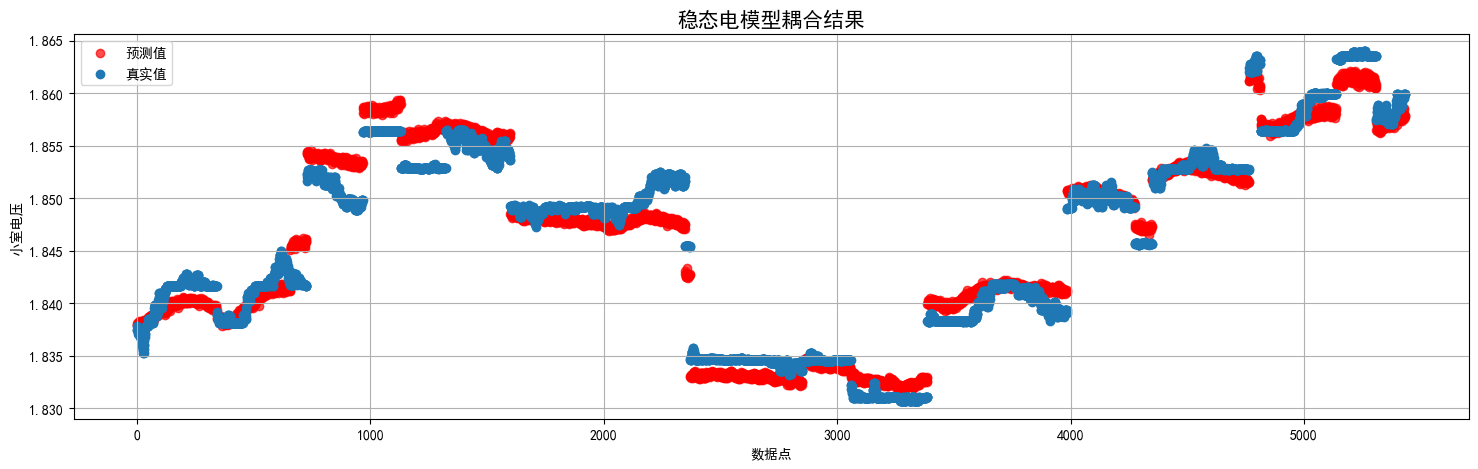

In [26]:
V_pred = cell_voltage_cal_empirical_formula(statistics=statistics_torch,
                                            **params)
V_pred_np = V_pred.cpu().detach().numpy()
cell_voltage_observed_np = cell_voltage_observed_torch.cpu().detach().numpy()

fig, ax1 = plt.subplots(figsize=(18,5))

ax1.scatter(range(len(V_pred_np)), V_pred_np, alpha = 0.7, c = 'r', label = '预测值')
ax1.scatter(range(len(V_pred_np)), cell_voltage_observed_np, label = '真实值')
ax1.legend(prop=prop)

plt.title('稳态电模型耦合结果', fontproperties=prop, fontsize = 15)
plt.xlabel('数据点', fontproperties=prop)
plt.ylabel('小室电压', fontproperties=prop)
plt.grid()

# 画极化曲线

In [27]:
t1=params['t1'].item()
t2=params['t2'].item()
t3=params['t3'].item()
r1=params['r1'].item()
r2=params['r2'].item()
s1=params['s1'].item()

c1=params['c1'].item()
c2=params['c2'].item()

In [28]:
  # 稳态电化学模型
def Static_Electrochemical_Model(Lye_temp, Temp_out, Current_density, Lye_flow, Pressure = 1.6):
    """电解电压的计算模型

    Args:
        Lye_temp (float): 进口温度，即碱液温度 ℃
        Temp_out (float): 出口温度℃
        Current_density (float): 电流密度 A/m2
        Lye_flow (float): 碱液流量 m3/h
        Pressure (float): 压力 MPa

    Returns:
        float: 电解小室电压 V
    """

    # 避免 T_in 或 T_out 为零
    Lye_temp = max(Lye_temp, 1e-10)
    Temp_out = max(Temp_out, 1e-10)

    lambda_flow = Lye_flow / Volume_active / 25 + 0.1

    temp_work = (1-lambda_flow) * Lye_temp * c1 + lambda_flow * Temp_out * c2

    # 避免 log 函数的负数输入
    log_input = max((t1 + t2 / temp_work + t3 / temp_work ** 2) * Current_density + 1, 1e-10)

    Vcell= 1.25 + (r1 + r2 * temp_work) * Current_density + s1 * math.log(log_input)

    return Vcell

d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


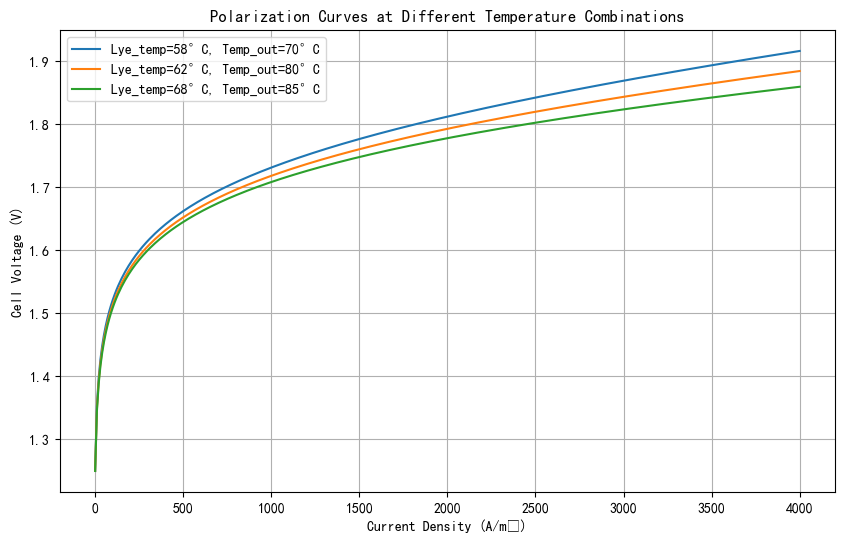

In [29]:
# 定义电流密度范围
current_densities = np.linspace(0, 4000, 400)

# 定义温度组合
temperature_combinations = [(58, 70), (62, 80), (68, 85)]

# 碱液流量和压力
Lye_flow = 0.4
Pressure = 1.6

# 初始化绘图
plt.figure(figsize=(10, 6))

# 遍历不同的温度组合
for Lye_temp, Temp_out in temperature_combinations:
    # 计算每个电流密度下的电池电压
    voltages = []
    for Current_density in current_densities:
        Vcell = Static_Electrochemical_Model(Lye_temp, Temp_out, Current_density, Lye_flow)
        voltages.append(Vcell)

    # 绘制极化曲线
    plt.plot(current_densities, voltages, label=f'Lye_temp={Lye_temp}°C, Temp_out={Temp_out}°C')

# 设置图表标题和标签
plt.title('Polarization Curves at Different Temperature Combinations')
plt.xlabel('Current Density (A/m²)')
plt.ylabel('Cell Voltage (V)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

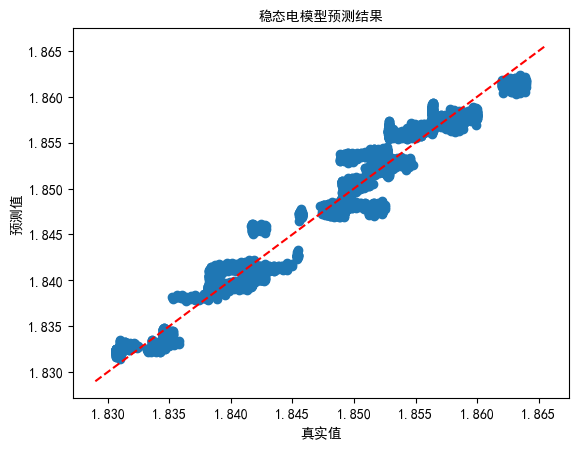

In [30]:
plt.scatter(cell_voltage_observed_np, V_pred_np)
plt.title('稳态电模型预测结果', fontproperties=prop)
plt.xlabel('真实值', fontproperties=prop)
plt.ylabel('预测值', fontproperties=prop)
# 获取当前的 Axes 对象
ax = plt.gca()
# 获取坐标轴的范围
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
# 确定对角线的端点
diag_min = min(x_min, y_min)
diag_max = max(x_max, y_max)
# 绘制对角线
plt.plot([diag_min, diag_max], [diag_min, diag_max], color='red', linestyle='--')

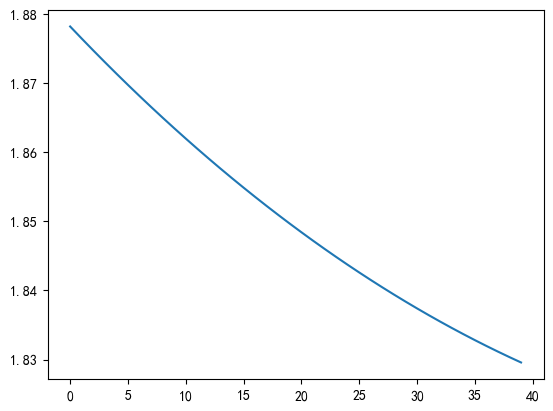

In [31]:
lye_flow_array = np.arange(0.3, 0.5, 0.005)
lye_temp_array = np.linspace(55, 75, len(lye_flow_array))
voltage_array = np.array([])

for i in range(len(lye_flow_array)):

    voltage = Static_Electrochemical_Model(Lye_temp = lye_temp_array[i],
                                                       Temp_out = 85,
                                                       Current_density = 3500,
                                                       Lye_flow = lye_flow_array[i],
                                                       Pressure=1.6)
    voltage_array = np.append(voltage_array, voltage)

plt.plot(voltage_array)